# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import re
import pandas as pd
import nltk
from sqlalchemy import create_engine
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,f1_score,recall_score,precision_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import pickle
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# load data from database
engine = create_engine('sqlite:///DisasterRespondent1.db')
df = pd.read_sql('SELECT * FROM data',engine)
X = df['message']
Y= df.drop(['id','message','original','genre'], axis=1)
categories_columns= Y.columns
categories_columns

Index(['related', 'request', 'offer', 'aid_related', 'medical_help',
       'medical_products', 'search_and_rescue', 'security', 'military',
       'child_alone', 'water', 'food', 'shelter', 'clothing', 'money',
       'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report'],
      dtype='object')

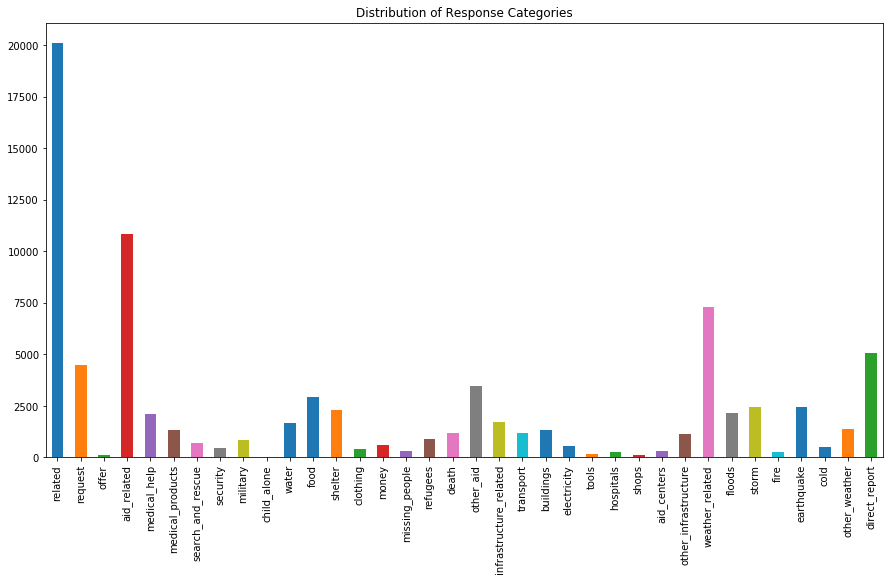

In [3]:
plt.figure(figsize=(15,8))
Y.sum().plot(kind='bar')
plt.title("Distribution of Response Categories")
plt.show()

### 2. Write a tokenization function to process your text data

In [4]:
def tokenize(text):
    
    text= re.sub(r"[^a-zA-Z0-9]"," ",text)
     # tokenize text
    tokens = word_tokenize(text) 
    tokens= [tok for tok in tokens if tok not in stopwords.words('english')]
    
    # initiate lemmatizer
    lemmatizer = WordNetLemmatizer()
    # iterate through each token
    clean_tokens = []
    for tok in tokens:
        
        # lemmatize, normalize case
        clean_tok = lemmatizer.lemmatize(tok, pos='v').lower()
        clean_tokens.append(clean_tok)

    return clean_tokens

for message in X[:3]:
    toks= tokenize(message)
    print(toks)

['weather', 'update', 'cold', 'front', 'cuba', 'could', 'pass', 'haiti']
['is', 'hurricane']
['looking', 'someone', 'name']


### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [5]:
#instantiate the pipeline class
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf',RandomForestClassifier(random_state= 42))
])

In [23]:
def get_metrics(test_value, predicted_value):
    """
    get_metrics calculates f1 score, accuracy and recall
    Args:
        test_value (list): list of actual values
        predicted_value (list): list of predicted values
    Returns:
        dictionray: a dictionary with accuracy, f1 score, precision and recall
    """
    accuracy = accuracy_score(test_value, predicted_value)
    precision = precision_score(
        test_value, predicted_value, average='micro')
    recall = recall_score(test_value, predicted_value, average='micro')
    f1 = f1_score(test_value, predicted_value, average='micro')
    return {'Accuracy': accuracy, 'f1 score': f1, 'Precision': precision, 'Recall': recall}

In [24]:
def compute_evaluation(Y_test,Y_train,predict_train,predict_test):
    """" function to evaluate each category dataset
    Args:
        Y_test(dataframe): dataframe for test dataset
        Y_train(dataframe): dataframe for train dataset
        predict_train(list): list of train predicted values
        predict_test(list): list of test predicted values
    Returns:
        metrics_train_df(df): train dataframe of evaluation metrics
        metrics_test_df(df): test dataframe of evaluation metrics
    """
    # get the accuracy score for each category on train dataset
    metric_train= []
    for i, column in enumerate(Y_test.columns):
        metrics= get_metrics(Y_train.loc[:,column].values, predict_train[:,i])
        metric_train.append(metrics)
    
    metrics_train_df= pd.DataFrame(metric_train)
    
    
    # get the accuracy score for each category on test dataset
    metric_test= []
    for i, column in enumerate(Y_test.columns):
        metrics = get_metrics(Y_test.loc[:, column].values, predict_test[:, i])
        metric_test.append(metrics)
    
    metrics_test_df= pd.DataFrame(metric_test)
    
    return metrics_train_df, metrics_test_df

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [8]:
# split dataset into train & test dataset
X_train, X_test,Y_train, Y_test=train_test_split(X,Y, random_state= 42)

#fit train dataset to pipeline and make prediction
pipeline.fit(X_train,Y_train)
y_preds_train= pipeline.predict(X_train)
y_preds_test= pipeline.predict(X_test)

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [26]:
train_df, test_df= compute_evaluation(Y_test,Y_train,y_preds_train,y_preds_test)
print("Average evaluation for pipeline train dataset")
print(train_df.mean())
train_df

Average evaluation for pipeline train dataset
Accuracy     0.992164
Precision    0.992164
Recall       0.992164
f1 score     0.992164
dtype: float64


,Accuracy,Precision,Recall,f1 score
0,0.991709,0.991709,0.991709,0.991709
1,0.987997,0.987997,0.987997,0.987997
2,0.998474,0.998474,0.998474,0.998474
3,0.979096,0.979096,0.979096,0.979096
4,0.984487,0.984487,0.984487,0.984487
5,0.991760,0.991760,0.991760,0.991760
6,0.993083,0.993083,0.993083,0.993083
7,0.995473,0.995473,0.995473,0.995473
8,0.994863,0.994863,0.994863,0.994863
9,1.000000,1.000000,1.000000,1.000000


In [10]:
print("Average evaluation for pipeline test dataset")
print(test_df.mean())
test_df

Average evaluation for pipeline test dataset
Accuracy     0.942567
Precision    0.942567
Recall       0.942567
f1 score     0.942567
dtype: float64


,Accuracy,Precision,Recall,f1 score
0,0.807904,0.807904,0.807904,0.807904
1,0.891517,0.891517,0.891517,0.891517
2,0.995117,0.995117,0.995117,0.995117
3,0.736649,0.736649,0.736649,0.736649
4,0.917760,0.917760,0.917760,0.917760
5,0.949344,0.949344,0.949344,0.949344
6,0.974825,0.974825,0.974825,0.974825
7,0.980775,0.980775,0.980775,0.980775
8,0.969332,0.969332,0.969332,0.969332
9,1.000000,1.000000,1.000000,1.000000


### 6. Improve your model
Use grid search to find better parameters. 

In [12]:
# select few parameters to tune the model
parameters = {
    'clf__min_samples_split': [3],
    'clf__n_estimators': [5]
}

cv = GridSearchCV(pipeline, param_grid=parameters, cv=2, verbose= 3)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [13]:
# fit the model
cv.fit(X_train,Y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] clf__min_samples_split=3, clf__n_estimators=5 ...................
[CV]  clf__min_samples_split=3, clf__n_estimators=5, score=0.2543993489980673, total= 1.5min
[CV] clf__min_samples_split=3, clf__n_estimators=5 ...................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min remaining:    0.0s


[CV]  clf__min_samples_split=3, clf__n_estimators=5, score=0.25768056968463887, total= 1.5min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.4min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...stimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__min_samples_split': [3], 'clf__n_estimators': [5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [14]:
# predict with the model
cv_preds_train = cv.predict(X_train)
cv_preds_test = cv.predict(X_test)

In [15]:
cv_train_df, cv_test_df= compute_evaluation(Y_test,Y_train,cv_preds_train,cv_preds_test)
print("Average evaluation metrics for train dataset after cross validation")
print(cv_train_df.mean())
cv_train_df

Average evaluation metrics for train dataset after cross validation
Accuracy     0.986969
Precision    0.986969
Recall       0.986969
f1 score     0.986969
dtype: float64


,Accuracy,Precision,Recall,f1 score
0,0.971924,0.971924,0.971924,0.971924
1,0.975942,0.975942,0.975942,0.975942
2,0.997457,0.997457,0.997457,0.997457
3,0.958954,0.958954,0.958954,0.958954
4,0.977621,0.977621,0.977621,0.977621
5,0.986827,0.986827,0.986827,0.986827
6,0.990387,0.990387,0.990387,0.990387
7,0.993744,0.993744,0.993744,0.993744
8,0.991913,0.991913,0.991913,0.991913
9,1.000000,1.000000,1.000000,1.000000


In [17]:
print("Average evaluation metrics for test dataset after cross validation")
print(cv_test_df.mean())
cv_test_df

Average evaluation metrics for test dataset after cross validation
Accuracy     0.942338
Precision    0.942338
Recall       0.942338
f1 score     0.942338
dtype: float64


,Accuracy,Precision,Recall,f1 score
0,0.801648,0.801648,0.801648,0.801648
1,0.884345,0.884345,0.884345,0.884345
2,0.995117,0.995117,0.995117,0.995117
3,0.723528,0.723528,0.723528,0.723528
4,0.919133,0.919133,0.919133,0.919133
5,0.949649,0.949649,0.949649,0.949649
6,0.974672,0.974672,0.974672,0.974672
7,0.980165,0.980165,0.980165,0.980165
8,0.969637,0.969637,0.969637,0.969637
9,1.000000,1.000000,1.000000,1.000000


### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [18]:
# knc
parameters = {
    'clf__n_neighbors':[1,2,3,4,5,6]
}


pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf',KNeighborsClassifier())
])

# instantiate grdisearchcv
knc_cv = GridSearchCV(pipeline, param_grid=parameters, cv=2, verbose= 3)

In [19]:
# fit the model
knc_cv.fit(X_train,Y_train)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] clf__n_neighbors=1 ..............................................
[CV] .... clf__n_neighbors=1, score=0.22571457634014852, total= 1.6min
[CV] clf__n_neighbors=1 ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min remaining:    0.0s


[CV] ..... clf__n_neighbors=1, score=0.1960325534079349, total= 1.6min
[CV] clf__n_neighbors=2 ..............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.9min remaining:    0.0s


[CV] .... clf__n_neighbors=2, score=0.23334350523853117, total= 1.6min
[CV] clf__n_neighbors=2 ..............................................
[CV] ..... clf__n_neighbors=2, score=0.2491353001017294, total= 1.6min
[CV] clf__n_neighbors=3 ..............................................
[CV] .... clf__n_neighbors=3, score=0.22388363340453668, total= 1.6min
[CV] clf__n_neighbors=3 ..............................................
[CV] .... clf__n_neighbors=3, score=0.21922685656154628, total= 1.6min
[CV] clf__n_neighbors=4 ..............................................
[CV] .... clf__n_neighbors=4, score=0.22663004780795443, total= 1.6min
[CV] clf__n_neighbors=4 ..............................................
[CV] ..... clf__n_neighbors=4, score=0.2491353001017294, total= 1.6min
[CV] clf__n_neighbors=5 ..............................................
[CV] .... clf__n_neighbors=5, score=0.22073034279320516, total= 1.6min
[CV] clf__n_neighbors=5 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 29.7min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...owski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__n_neighbors': [1, 2, 3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [20]:
# make predictions
knc_preds_train = knc_cv.predict(X_train)
knc_preds_test = knc_cv.predict(X_test)

In [22]:
knc_train_df, knc_test_df= compute_evaluation(Y_test,Y_train,knc_preds_train,knc_preds_test)
print("Average evaluation metrics for train dataset after k-nearest modelling")
print(knc_train_df.mean())
train_df

Average evaluation metrics for train dataset after k-nearest modelling
Accuracy     0.930459
Precision    0.930459
Recall       0.930459
f1 score     0.930459
dtype: float64


,Accuracy,Precision,Recall,f1 score
0,0.991709,0.991709,0.991709,0.991709
1,0.987997,0.987997,0.987997,0.987997
2,0.998474,0.998474,0.998474,0.998474
3,0.979096,0.979096,0.979096,0.979096
4,0.984487,0.984487,0.984487,0.984487
5,0.991760,0.991760,0.991760,0.991760
6,0.993083,0.993083,0.993083,0.993083
7,0.995473,0.995473,0.995473,0.995473
8,0.994863,0.994863,0.994863,0.994863
9,1.000000,1.000000,1.000000,1.000000


In [28]:
print("Average evaluation metrics for test dataset after k-nearest modelling")
print(knc_test_df.mean())
test_df

Average evaluation metrics for test dataset after k-nearest modelling
Accuracy     0.92925
Precision    0.92925
Recall       0.92925
f1 score     0.92925
dtype: float64


,Accuracy,Precision,Recall,f1 score
0,0.807904,0.807904,0.807904,0.807904
1,0.891517,0.891517,0.891517,0.891517
2,0.995117,0.995117,0.995117,0.995117
3,0.736649,0.736649,0.736649,0.736649
4,0.917760,0.917760,0.917760,0.917760
5,0.949344,0.949344,0.949344,0.949344
6,0.974825,0.974825,0.974825,0.974825
7,0.980775,0.980775,0.980775,0.980775
8,0.969332,0.969332,0.969332,0.969332
9,1.000000,1.000000,1.000000,1.000000


### 9. Export your model as a pickle file

In [ ]:
# save pipeline model to file
with open('pipeline_model.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

In [ ]:
# save tuned pipeline model to file
with open('cv_model.pkl', 'wb') as file:
    pickle.dump(cv, file)

In [ ]:
# save kneighbor classifier model to file
with open('knc_model.pkl', 'wb') as file:
    pickle.dump(knc_cv, file)